In [1]:
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, transpile, qasm2, qasm3
from qiskit_aer import Aer
from qiskit.primitives import BackendSampler
from qiskit.providers.basic_provider import BasicProvider # instead of BasicAer
import Our_Qiskit_Functions as oq
import numpy as np
import math as m
import scipy as sci
import random
import matplotlib
import matplotlib.pyplot as plt
from itertools import permutations
S_simulator = Aer.backends(name='statevector_simulator')[0]

In [2]:
def E(m1,m2,q):
    return abs(m1-m2)*2*q**4 - abs(m1+m2)*10*q**2 + 25
#=====================================================
D = 10
M = [1,2,3]
GS = [999,0,0,0]
N = 100
for i in np.arange(N):
    d12 = round(i/N,4)*D
    for j in np.arange(N):
        d13 = round((j/N)*(D-d12),4)
        d23 = round((D-d12-d13),4)
        Etotal = E(M[0],M[1],d12) + E(M[0],M[2],d13) + E(M[1],M[2],d23)
        if( Etotal < GS[0] ):
            GS = [Etotal,d12,d13,d23]
print('Total Particle Distance: ',D,' Particle Masses m1: ',M[0],' m2: ',M[1],' m3: ',M[2])
print('\nMinimal Total Energy: ',round(GS[0],4))
print('\nDistances Between Particles: 1-2: ',round(GS[1],3),' 1-3: ',round(GS[2],3),' 2-3: ',round(GS[3],3))
print('\nEnergy Contributions: 1-2: ',round(E(M[0],M[1],GS[1]),2),' 1-3: ',round(E(M[0],M[2],GS[2]),2), ' 2-3: ',round(E(M[1],M[2],GS[3]),2))

Total Particle Distance:  10  Particle Masses m1:  1  m2:  2  m3:  3

Minimal Total Energy:  -381.5408

Distances Between Particles: 1-2:  3.3  1-3:  2.747  2-3:  3.953

Energy Contributions: 1-2:  -64.52  1-3:  -49.07  2-3:  -267.95


In [3]:
def Single_Qubit_Ansatz( qc, qubit, params ):
    qc.ry( params[0], qubit )
    qc.rz( params[1], qubit )
#================================================
q = QuantumRegister( 1, name='q' )
qc= QuantumCircuit( q, name='qc' )
theta = m.pi/3
phi = 3*m.pi/2
print('___ Initial State ___')
oq.Wavefunction( qc )
Single_Qubit_Ansatz( qc, q[0], [theta,phi] )
print('\n___ After U(\u03B8,\u03C6) ___')
oq.Wavefunction( qc )
print(' ')
print(qc)

___ Initial State ___
1.0  |0>   

___ After U(θ,φ) ___
-0.61237-0.61237j |0>   -0.35355+0.35355j |1>   
 
   ┌─────────┐┌──────────┐
q: ┤ Ry(π/3) ├┤ Rz(3π/2) ├
   └─────────┘└──────────┘


In [4]:
Shots = 10000
#============================================
q = QuantumRegister(1,name='q')
c = ClassicalRegister(1,name='c')
qc= QuantumCircuit(q,c,name='qc')
qc.initialize( [m.sqrt(1/4),m.sqrt(3/4)], q[0] )
print(' ___ Ansatz State ___')
oq.Wavefunction( qc )
qc.measure(q,c)
M1 = oq.Measurement( qc, shots=Shots, print_M=False, return_M=True )
print( '\n{ |0> , |1> } Basis - Energy Expectation Value: ',round( (M1['0']/Shots)+(-1.0*M1['1']/Shots) ,3) )
#============================================
q2 = QuantumRegister(1,name='q2')
c2 = ClassicalRegister(1,name='c2')
qc2= QuantumCircuit(q2,c2,name='qc2')
qc.initialize( [m.sqrt(1/4),m.sqrt(3/4)], q[0] )
qc2.ry( -m.pi/2, q2[0] )
qc2.measure(q2,c2)
M2 = oq.Measurement( qc2, shots=Shots, print_M=False, return_M=True )
print( '\n{ |+> , |-> } Basis - Energy Expectation Value: ',round( (M2['0']/Shots)+(-1.0*M2['1']/Shots) ,3) )

 ___ Ansatz State ___
0.5  |0>   0.86603  |1>   

{ |0> , |1> } Basis - Energy Expectation Value:  -0.49

{ |+> , |-> } Basis - Energy Expectation Value:  -0.01


Ground State Energy:  -3.7596  θ =  1.885  φ =  2.723


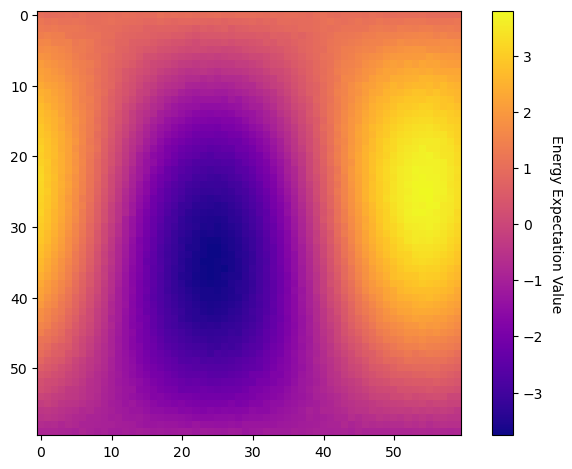

In [5]:
t1 = 60
t2 = 60
Shots = 10000
Parameter_Space = np.zeros(shape=(t1,t2))
Ground_State = [100,0,0]
H = {'X':3,'Y':-2,'Z':1}
Hk = list( H.keys() )
#--------------------------------------------------
for i in np.arange( t1 ):
    theta = m.pi*(i/t1)
    for j in np.arange( t2 ):
        phi = 2*m.pi*(j/t2)
        Measures = []
        for k in np.arange(len(Hk)):
            q = QuantumRegister( 1, name='q' )
            c = ClassicalRegister( 1, name='c' )
            qc= QuantumCircuit( q, c, name='qc')
            oq.Single_Qubit_Ansatz( qc, q[0], [theta, phi] )
            if( Hk[k] == 'X' ):
                qc.ry( -m.pi/2, q[0])
            elif( Hk[k] == 'Y' ):
                qc.rx(m.pi/2, q[0])
            qc.measure( q,c )
            M = {'0':0,'1':0}
            M.update( oq.Measurement( qc, shots=Shots, print_M=False, return_M=True ) )
            Measures.append( M )
        Parameter_Space[i,j] = H['X']*(Measures[0]['0'] - Measures[0]['1'])/Shots + H['Y']*(Measures[1]['0'] - Measures[1]['1'])/Shots + H['Z']*(Measures[2]['0'] - Measures[2]['1'])/Shots
        if( Parameter_Space[i,j] < Ground_State[0] ):
            Ground_State[0] = Parameter_Space[i,j]
            Ground_State[1] = theta
            Ground_State[2] = phi
#==================================================
print('Ground State Energy: ',round(Ground_State[0],5),' \u03B8 = ',round(Ground_State[1],3),' \u03C6 = ',round(Ground_State[2],3))
fig, ax = plt.subplots()
show_text = False
show_ticks = False
oq.Heatmap(Parameter_Space, show_text, show_ticks, ax, "plasma", "Energy Expectation Value")
fig.tight_layout()
plt.show()

In [6]:
H = {'X':3,'Y':-2,'Z':1}
Hk = list( H.keys() )
Shots = 100000
Ground_State = [100,0,0]
epsilon = 0.001
step_size = 0.01
delta = 0.0001
M_bool = True
#-----------------------
EV = 100
EV_old = 1000
terminate = False
#========================================================
theta = m.pi*random.random()
phi = 2*m.pi*random.random()
iters = 0
while( (abs( EV - EV_old ) > delta) and (terminate==False) ):
    EV_old = EV
    EV = 0
    for k in np.arange(len(Hk)):
        q = QuantumRegister( 1, name='q' )
        c = ClassicalRegister( 1, name='c' )
        qc= QuantumCircuit( q, c, name='qc')
        oq.Single_Qubit_Ansatz( qc, q[0], [theta, phi] )
        if( Hk[k] == 'X' ):
            qc.ry(-m.pi/2, q[0])
        elif( Hk[k] == 'Y' ):
            qc.rx(m.pi/2, q[0])
        qc.measure( q,c )
        M = {'0':0,'1':0}
        M.update( oq.Measurement( qc, shots=Shots, print_M=False, return_M=True ) )
        EV = EV + H[Hk[k]]*(M['0']-M['1'])/Shots
    print('Iterations: ',iters,' EV: ',round(EV,5),' \u03B8 = ',round(theta,5),' \u03C6 = ',round(phi,5))
    if( EV > EV_old ):
        terminate = True
    else:
        if( EV < Ground_State[0] ):
            Ground_State[0] = EV
            Ground_State[1] = theta
            Ground_State[2] = phi
    theta_old = theta
    phi_old = phi
    theta,phi = oq.VQE_Gradient_Descent(qc,q,H,oq.Single_Qubit_Ansatz,theta,phi,epsilon,step_size,measure=M_bool,shots=Shots)
    iters = iters + 1
if( (abs( EV - EV_old ) < delta) or (terminate==True) ):
    print('\n_____ Gradient Descent Complete _____\n')
    print('Iterations: ',iters,' EV: ',round(Ground_State[0],5),' \u03B8 = ',round(Ground_State[1],5),' \u03C6 = ',round(Ground_State[2],5))

Iterations:  0  EV:  3.72844  θ =  1.37507  φ =  5.72859
Iterations:  1  EV:  3.72226  θ =  1.37227  φ =  5.75729
Iterations:  2  EV:  3.72686  θ =  1.36757  φ =  5.66619

_____ Gradient Descent Complete _____

Iterations:  3  EV:  3.72226  θ =  1.37227  φ =  5.75729


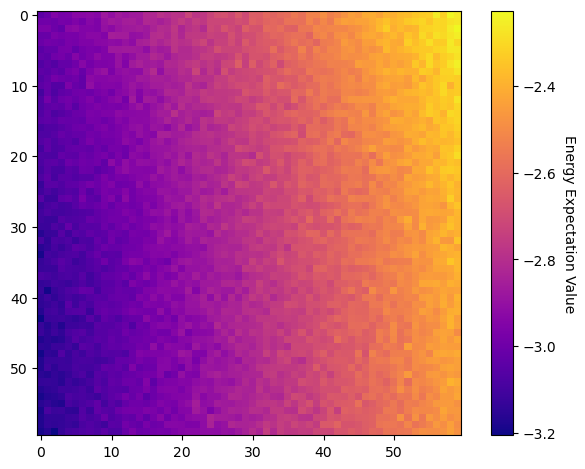

In [7]:
t1 = 60
t2 = 60
Shots = 10000
Parameter_Space = np.zeros(shape=(t1,t2))
Ground_State = [100,0,0]
H = {'X':3,'Y':-2,'Z':1}
Hk = list( H.keys() )
#--------------------------------------------------
for i in np.arange( t1 ):
    theta = m.pi/2+ (m.pi/10)*(i/t1)
    #theta = m.pi*(i/t1)
    for j in np.arange( t2 ):
        phi = m.pi+ (m.pi/10)*(j/t2)
        #phi = 2*m.pi*(j/t2)
        EV = 0
        for k in np.arange(len(Hk)):
            q = QuantumRegister( 1, name='q' )
            c = ClassicalRegister( 1, name='c' )
            qc= QuantumCircuit( q, c, name='qc')
            oq.Single_Qubit_Ansatz( qc, q[0], [theta, phi] )
            if( Hk[k] == 'X' ):
                qc.ry(-m.pi/2, q[0])
            elif( Hk[k] == 'Y' ):
                qc.rx(m.pi/2, q[0])
            qc.measure( q,c )
            M = {'0':0,'1':0}
            M.update( oq.Measurement( qc, shots=Shots, print_M=False, return_M=True ) )
            EV = EV + H[Hk[k]]*(M['0']-M['1'])/Shots
        Parameter_Space[i,j] = EV
        if( Parameter_Space[i,j] < Ground_State[0] ):
            Ground_State[0] = Parameter_Space[i,j]
            Ground_State[1] = theta
            Ground_State[2] = phi
#==================================================
fig, ax = plt.subplots()
show_text = False
show_ticks = False
oq.Heatmap(Parameter_Space, show_text, show_ticks, ax, "plasma", "Energy Expectation Value")
fig.tight_layout()
plt.show()

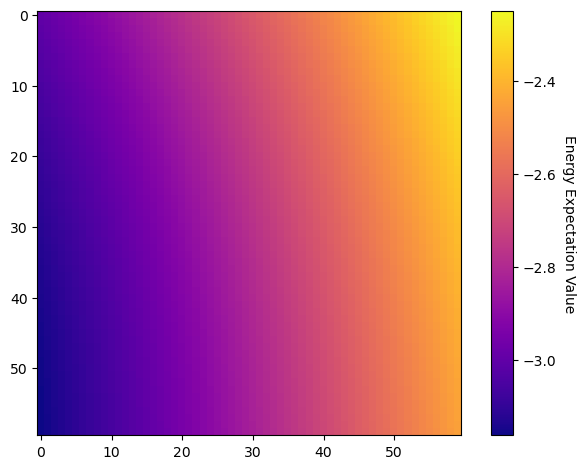

In [9]:
t1 = 60
t2 = 60
Parameter_Space = np.zeros(shape=(t1,t2))
Ground_State = [100,0,0]
H = {'X':3,'Y':-2,'Z':1}
Hk = list( H.keys() )
#--------------------------------------------------
for i in np.arange( t1 ):
    theta = m.pi/2+ (m.pi/10)*(i/t1)
    for j in np.arange( t2 ):
        phi = m.pi+ (m.pi/10)*(j/t2)
        EV = 0
        for k in np.arange(len(Hk)):
            q = QuantumRegister( 1, name='q' )
            qc= QuantumCircuit( q, name='qc')
            oq.Single_Qubit_Ansatz( qc, q[0], [theta, phi] )
            sv0 = oq.execute( qc, S_simulator, shots=1 ).result().get_statevector()
            if( Hk[k] == 'X' ):
                qc.x(q[0])
            elif( Hk[k] == 'Y' ):
                qc.y(q[0])
            elif( Hk[k] == 'Z' ):
                qc.z(q[0])
            sv = oq.execute( qc, S_simulator, shots=1 ).result().get_statevector()
            ev = 0
            for k2 in range(len(np.asarray(sv))):
                ev = ev + (np.conj(sv[k2])*sv0[k2]).real
            EV = EV + H[Hk[k]] * ev
        Parameter_Space[i,j] = EV
        if( Parameter_Space[i,j] < Ground_State[0] ):
            Ground_State[0] = Parameter_Space[i,j]
            Ground_State[1] = theta
            Ground_State[2] = phi
#==================================================
fig, ax = plt.subplots()
show_text = False
show_ticks = False
oq.Heatmap(Parameter_Space, show_text, show_ticks, ax, "plasma", "Energy Expectation Value")
fig.tight_layout()
plt.show()

In [10]:
H = {'X':3,'Y':-2,'Z':1}
Hk = list( H.keys() )
Ground_State = [100,0,0]
epsilon = 0.05
step_size = 0.01
delta = 0.00005
M_bool = False
#-----------------------
EV = 100
EV_old = 1000
terminate=False
EV_type = 'wavefunction'
#========================================================
theta = m.pi*random.random()
phi = 2*m.pi*random.random()
iters = 0
while( (abs( EV - EV_old ) > delta) and (terminate==False) ):
    EV_old = EV
    EV = oq.VQE_EV([theta,phi],oq.Single_Qubit_Ansatz,H,EV_type)
    if( (iters/10.0)==m.ceil(iters/10.0) ):
        print('Iterations: ',iters,' EV: ',round(EV,5),' \u03B8 = ',round(theta,5),' \u03C6 = ',round(phi,5))
    if( EV > EV_old ):
        terminate = True
    else:
        if( EV < Ground_State[0] ):
            Ground_State[0] = EV
            Ground_State[1] = theta
            Ground_State[2] = phi
        theta_old = theta
        phi_old = phi
        theta,phi = oq.VQE_Gradient_Descent(qc,q,H,oq.Single_Qubit_Ansatz,theta,phi,epsilon,step_size,measure=M_bool)
        iters = iters + 1
if( (abs( EV - EV_old ) < delta) or (terminate==True) ):
    print('\n_____ Gradient Descent Complete _____\n')
    print('Iterations: ',iters,' EV: ',round(Ground_State[0],5),' \u03B8 = ',round(Ground_State[1],5),' \u03C6 = ',round(Ground_State[2],5))

Iterations:  0  EV:  -0.34751  θ =  2.01417  φ =  4.14941
Iterations:  10  EV:  -1.39229  θ =  2.0826  φ =  3.83318
Iterations:  20  EV:  -2.19867  θ =  2.09577  φ =  3.54912
Iterations:  30  EV:  -2.78632  θ =  2.07029  φ =  3.30752
Iterations:  40  EV:  -3.18613  θ =  2.02774  φ =  3.11154
Iterations:  50  EV:  -3.43579  θ =  1.98371  φ =  2.95924
Iterations:  60  EV:  -3.57993  θ =  1.9458  φ =  2.84488
Iterations:  70  EV:  -3.65845  θ =  1.91609  φ =  2.76107
Iterations:  80  EV:  -3.69959  θ =  1.894  φ =  2.70062
Iterations:  90  EV:  -3.72062  θ =  1.87806  φ =  2.65744
Iterations:  100  EV:  -3.73121  θ =  1.86678  φ =  2.62679
Iterations:  110  EV:  -3.73649  θ =  1.85889  φ =  2.60513
Iterations:  120  EV:  -3.73911  θ =  1.85341  φ =  2.58984
Iterations:  130  EV:  -3.7404  θ =  1.84963  φ =  2.57907

_____ Gradient Descent Complete _____

Iterations:  140  EV:  -3.741  θ =  1.84724  φ =  2.57214


In [11]:
H = {'X':3,'Y':-2,'Z':1}
EV_type = 'measure'
theta = random.random()*m.pi
phi = random.random()*2*m.pi
delta = 0.001
#------------------------------
Vertices = []
Values = []
radius = 0.35
R = random.random()*(2*m.pi/3)
for rr in np.arange(3):
    angle = R+ rr*2*m.pi/3
    Vertices.append( [theta+radius*m.cos(angle),phi+radius*m.sin(angle)] )
for v in np.arange(len(Vertices)):
    Values.append( oq.VQE_EV(Vertices[v],oq.Single_Qubit_Ansatz,H,EV_type) )
#------------------------------
terminate = False
iters = 0
terminate_count = 0
terminate_limit = 6
while( (terminate==False) and (iters < 100) ):
    iters = iters + 1
    low = oq.Calculate_MinMax( Values,'min' )
    oq.Nelder_Mead(H, oq.Single_Qubit_Ansatz, Vertices, Values, EV_type)
    new_low = oq.Calculate_MinMax( Values,'min' )
    if( abs( new_low[0] - low[0] ) < delta ):
        terminate_count = terminate_count + 1
    else:
        terminate_count = 0
    if( terminate_count >= terminate_limit ):
        terminate = True
        print('\n_____ Nelder-Mead Complete _____\n')
        print('Iteration: ',iters,' Lowest EV: ',round(low[0],6),' \u03B8 = ',round(Vertices[low[1]][0],4),' \u03C6 = ',round(Vertices[low[1]][1],4))
    if( ( (iters==1) or (m.ceil(iters/5))==m.floor(iters/5) ) and (terminate==False) ):
        print('Iteration: ',iters,' Lowest EV: ',round(low[0],6),' \u03B8 = ',round(Vertices[low[1]][0],4),' \u03C6 = ',round(Vertices[low[1]][1],4))

Iteration:  1  Lowest EV:  -2.493  θ =  3.165  φ =  2.6615
Iteration:  5  Lowest EV:  -3.583  θ =  1.8307  φ =  2.2758
Iteration:  10  Lowest EV:  -3.7374  θ =  1.8898  φ =  2.543
Iteration:  15  Lowest EV:  -3.7666  θ =  1.8214  φ =  2.5703
Iteration:  20  Lowest EV:  -3.792  θ =  1.804  φ =  2.5863

_____ Nelder-Mead Complete _____

Iteration:  24  Lowest EV:  -3.792  θ =  1.804  φ =  2.5863


In [12]:
H = {'XY':3,'ZZ':-2}
EV_type = 'measure'
P = []
for p in np.arange(4):
    P.append( random.random()*m.pi )
    P.append( random.random()*2*m.pi )
delta = 0.001
#------------------------------
Vertices = []
Values = []
for v1 in np.arange(len(P)):
    V = []
    for v2 in np.arange(len(P)):
        R = (0.4+random.random()*0.8)*(-1)**round(random.random())
        V.append( P[v2]+R )
    Vertices.append( V )
    Values.append( oq.VQE_EV(V,oq.Two_Qubit_Ansatz,H,EV_type) )
#------------------------------
terminate = False
iters = 0
terminate_count = 0
terminate_limit = 10
while( (terminate==False) and (iters < 100) ):
    iters = iters + 1
    low = oq.Calculate_MinMax( Values,'min' )
    oq.Nelder_Mead(H, oq.Two_Qubit_Ansatz, Vertices, Values, EV_type)
    new_low = oq.Calculate_MinMax( Values,'min' )
    if( abs( new_low[0] - low[0] ) < delta ):
        terminate_count = terminate_count + 1
    else:
        terminate_count = 0
    if( terminate_count >= terminate_limit ):
        terminate = True
        print('\n_____ Nelder-Mead Complete _____\n')
        print(' --------------------- \n Iteration: ',iters,' Lowest EV: ',round( low[0],6 ))
    if( ( (iters==1) or (m.ceil(iters/10))==m.floor(iters/10) ) and (terminate==False) ):
        print('Iteration: ',iters,' Lowest EV: ',round( low[0],6 ))

Iteration:  1  Lowest EV:  -3.805
Iteration:  10  Lowest EV:  -3.805
Iteration:  20  Lowest EV:  -4.2274
Iteration:  30  Lowest EV:  -4.3928
Iteration:  40  Lowest EV:  -4.4122
Iteration:  50  Lowest EV:  -4.4162

_____ Nelder-Mead Complete _____

 --------------------- 
 Iteration:  55  Lowest EV:  -4.4162
